In [52]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
nodes = pd.read_csv("terrorist_attack.nodes", header = None, sep="\t", encoding="utf-8")
edges = pd.read_csv("terrorist_attack_loc.edges", header = None, sep="\t", encoding="utf-8")
labels = pd.read_csv("terrorist_attack.labels", header = None, sep="\t", encoding="utf-8")
edges = edges[0].str.split(' ',expand=True)
labels_extracted = nodes[107].str.split('#',expand=True)
labels = labels_extracted[1]

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
1,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
2,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
3,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
4,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
5,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
6,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
7,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
8,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
9,http://counterterror.mindswap.org/2005/ict_eve...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...


### Adjacency Matrix:

In [13]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
number_link = 0
n2 = 0

for idx, row in edges.iterrows():
    
    i = np.where(nodes[0] == row.loc[0])
    j = np.where(nodes[0] == row.loc[1])
    n2 = n2 + 1
    
    if (i[0].size != 0 and j[0].size != 0):
        adjacency[i[0], j[0]] = 1
        adjacency[j[0], i[0]] = 1
        number_link = number_link + 1

In [14]:
adjacency.shape

(1293, 1293)

Text(0.5, 1.05, 'adjacency matrix')

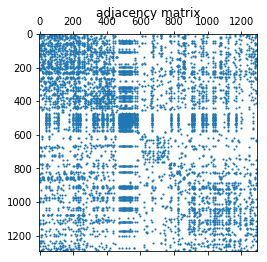

In [15]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')

### 

In [16]:
degree =  sum(adjacency)

assert len(degree) == n_nodes

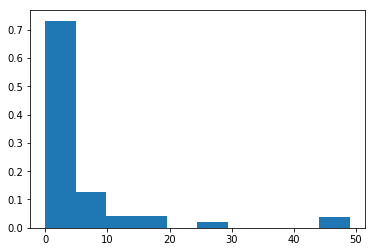

In [17]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

Giant Component 

In [18]:
G = nx.from_numpy_matrix(adjacency)
graphs = nx.connected_component_subgraphs(G)
graphs = list(graphs)
print(len(graphs))

787


In [19]:
giant = max(nx.connected_component_subgraphs(G), key=len)

In [20]:
A = nx.to_scipy_sparse_matrix(giant)
giant_component = A.todense()

In [21]:
giant_component.shape

(51, 51)

In [70]:
giant_component
GG = nx.from_numpy_matrix(giant_component)

### Laplacian 

In [ ]:
deg_matrix = np.diag(degree)
laplacian_combinatorial =  scipy.sparse.csr_matrix(deg_matrix - adjacency)

### Graph Plot


C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


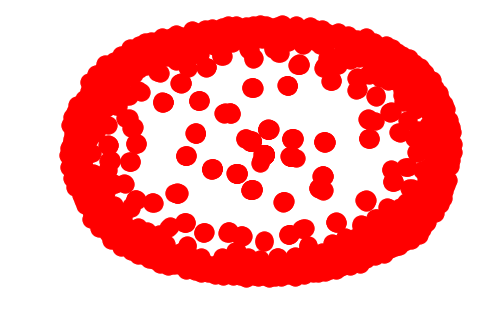

In [28]:
nx.draw(G)

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


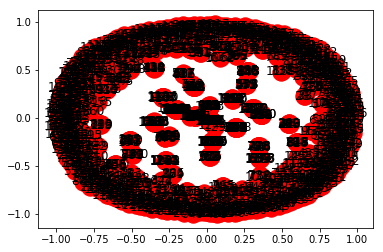

In [32]:
nx.draw_networkx(G)

In [59]:
G_test = nx.Graph()

In [60]:
G_test.add_nodes_from(nodes[0])

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


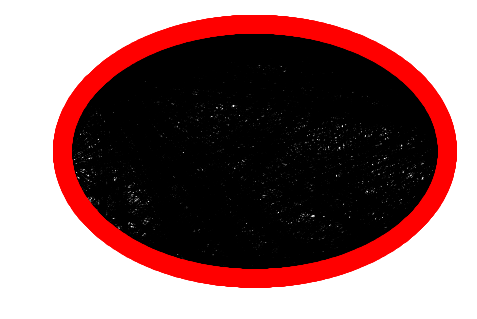

C:\Users\joelle hanna\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


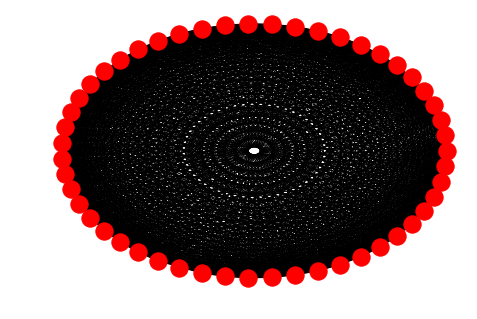

In [72]:
nx.draw_shell(GG)